In [1]:
%load_ext autoreload
%autoreload 2

## Kornia Training 

1. Trained with Kornia dataloader and augmntation
2. Trained with hdf5 dataset
3. Compared hdf5 and images . no comparative difference . in per epoch
4. ToDo: Per class acuracy 
5. Used fp16 precision training 
6. Usd pin_memory and persistent_workers : not much progress


In [2]:
import os
import torch
import shutil
import numpy as np
import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt

from typing import List

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pytorch_lightning as pl
import torchmetrics
import segmentation_models_pytorch as smp


#import albumentations as A
#from albumentations.pytorch import ToTensorV2

import evidence_loss
import torch.nn.functional as F

from torch import Tensor
import h5py
import io

In [3]:
from kornia import image_to_tensor, tensor_to_image
from kornia.augmentation import ColorJitter, RandomChannelShuffle, RandomThinPlateSpline
from kornia.augmentation import RandomVerticalFlip, RandomHorizontalFlip, Resize, RandomCrop, RandomMotionBlur
from kornia.augmentation import RandomEqualize, RandomGaussianBlur, RandomGaussianNoise, RandomSharpness
import kornia as K

## Data Augmentation

In [4]:
class DataAugmentation(torch.nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""

    def __init__(self, apply_color_jitter: bool = False) -> None:
        super().__init__()
        self._apply_color_jitter = apply_color_jitter

        self.transforms = torch.nn.Sequential(
            #RandomHorizontalFlip(p=0.50),
            #Resize(size=(64,64)),
            RandomChannelShuffle(p=0.50),
            RandomThinPlateSpline(p=0.50),
            RandomEqualize(p=0.5),
            RandomGaussianBlur((3, 3), (0.1, 2.0), p=0.2),
            RandomGaussianNoise(mean=0., std=1., p=0.2),
            RandomSharpness(0.5, p=0.5)
        )

        
        self.jitter = ColorJitter(0.5, 0.5, 0.5, 0.5)

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: Tensor) -> Tensor:
        x_out = self.transforms(x)  # BxCxHxW
        if self._apply_color_jitter:
            x_out = self.jitter(x_out)
        return x_out
    
class Preprocess(torch.nn.Module):
    """Module to perform pre-process using Kornia on torch tensors."""
    def __init__(self) -> None:
        super().__init__()
        self.resize = Resize(size=(64,64))
        #self.crop = RandomCrop(size=(64,64), cropping_mode="slice")

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, image: np.array, mask: np.array) -> Tensor:
        #x_tmp: np.ndarray = np.array(image)  # HxWxC
        x_out: Tensor = image_to_tensor(image, keepdim=True)  # CxHxW
        x_out: Tensor = self.resize(x_out.float()).squeeze(dim=0)
        #x_tmp: np.ndarray = np.array(mask)  # HxWxC
        mask_out: Tensor = image_to_tensor(mask).squeeze(dim=0)
        mask_out: Tensor = self.resize(mask_out.float()).squeeze(dim=0).squeeze(dim=0)
        return {'image':x_out.float() / 255.0, 'mask':mask_out.long()}

In [5]:
x = np.random.rand(5,5)
x = image_to_tensor(x, keepdim=True).squeeze(dim=0)
print (x.shape)
resize = Resize(size=(3,3))
resize(x.float()).squeeze(dim=0).squeeze(dim=0).shape

torch.Size([5, 5])


torch.Size([3, 3])

## Data loader 

In [20]:

class SingleImageVirtualKittiDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        root: str, 
        mode: str = "train", 
        transforms = None):

        assert mode in {"train", "valid", "test"}
        
        self.mode = mode
        self.transforms = transforms

        self.files_directory = root
  
        self.data_column_names=['scene', 'scenario', 'camera_number', 'frame_number', 'extrinsic']
        
        #Filenames extracted as a pandas dataframe
        self.filenames = self._read_split()  # read train/valid/test splits
        self.mask_colors = pd.read_csv(os.path.join(self.files_directory, 
                                               'colors.txt'), delimiter=' ')
        self.mask_colors['mask_label'] = self.mask_colors.index
        #Replacing the follwing
        #[GuardRail, TrafficLight, Pole, Truck, Van, Undefined] -> 
        #[Misc,      TrafficSign,  Misc, Car,   Car, Misc]
        self.mask_colors['mask_label'] =self.mask_colors['mask_label'].replace([6, 9, 10, 14, 7, 8, 11, 12, 13], 
                                                                    [8, 8, 8, 8, 6, 6, 7, 7, 7])
        print ("Total classes ", len(self.mask_colors['mask_label'].unique()))
        print ("Total classes ", (self.mask_colors['mask_label'].unique()))
        #Final classes are
        self.mask_colors = self.mask_colors.values.tolist()
      
    def __len__(self) -> int:
        return len(self.filenames)
    
    def __getitem__(self, idx: int) -> dict:

        _, scene, scenario, camera, frame_number, x = self.filenames[idx]
        data_filename = scene+'_'+scenario+'_'+camera+'_'+str(frame_number).zfill(5)+'.h5'
        data_filename = os.path.join(self.files_directory, data_filename)
        sample = {}
        #Reading image as numpy
        with h5py.File(data_filename, 'r') as data: 
            sample['image'] = np.asarray(Image.open(io.BytesIO(np.array(data['image']))))
            sample['mask'] = np.asarray(Image.open(io.BytesIO(np.array(data['mask']))))
            sample['depth'] = np.asarray(Image.open(io.BytesIO(np.array(data['depth']))))
            transformation_matrices=np.array(data['extrinsic'])
            #Was geting a user warning that array is not writeable and pytroch needs writeable
            sample['image'] = np.copy(sample['image'])
            sample['mask'] = np.copy(sample['mask'])
            sample['depth'] = np.copy(sample['depth'])
            

        sample['mask'] = self._preprocess_mask(sample['mask'])
        
        #Applies transformation and converts to tensor
        if self.transforms is not None:            
            transformed = self.transforms(image=sample['image'], mask=sample['mask'])

            sample['image'] = transformed['image']
            sample['mask'] = transformed['mask'].long()
        

        return sample
    
    def _preprocess_mask(self, mask: np.ndarray) -> np.ndarray:
        ''' 
        Convert RGB mask to single channel mask based on the color value
        provided in color.txt file 
        
        Parameters:
            mask: Numpy array mask of shape [height, width, 3]
            out: Numpy array of shape [height, width]
        '''
        preprocessed_mask = np.zeros(mask.shape[:2])
        for index, row in enumerate(self.mask_colors):
            # The columns of  mask_color dataframe is ['Terrain', r, g, b, mask_label]
            idx = np.all(mask == (row[1], row[2], row[3]), axis=-1) #
            preprocessed_mask[idx] = row[4]

        return preprocessed_mask

    def _read_split(self) -> list:
        ''' 
        Parses the virual kitti dataset and converts to a pandas dataframe
        
        Parameters:
            out: A list
        '''

        filenames = pd.read_csv(self.files_directory+'/virtual_kiti_file_naming.csv')
        
        if self.mode == "train":  # 90% for train
            # Creating a dataframe with 50%
            filenames = filenames.sample(frac = 0.9, random_state=55)
        elif self.mode == "valid":  # 10% for validation
            #sampling the same files with the random_state and droping them
            train_filenames = filenames.sample(frac = 0.9, random_state=55)
            filenames = filenames.drop(train_filenames.index)
            
        return filenames.values.tolist()



## Model

In [21]:
class VirtualKittiDataset(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        
        self.transform = DataAugmentation()  # per batch augmentation_kornia
     
        # for image segmentation dice loss could be the best first choice
        #self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
        self.loss_fn = evidence_loss.edl_mse_loss
        self.n_classes = out_classes
        
        self.epoch = 0
        self.lr = 0.0001
        
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.train_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
        self.valid_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
        

    def forward(self, image):
        # normalize image here
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4
        bs, num_channels, height, width = image.size()

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        # Shape of the mask should be [batch_size, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 3
        
        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 255.0 and mask.min() >= 0
      
        #unroll the tensor to single tensor 
        # [batch_size, height, width] -> [batch_size*height*width]
        mask = torch.ravel(mask)
        # [batch_size*height*width] -> [batch_size*height*width, n_classes] 
        mask = F.one_hot(mask.to(torch.long), self.n_classes)
        
        logits_mask = self.forward(image)
        # [batch_size, n_classes, height, width] -> [batch_size,n_classes, height*width]
        logits_mask = logits_mask.view(bs, self.n_classes, -1) 
        # [batch_size,n_classes, height*width] -> [batch_size, height*width, n_classes]
        logits_mask = logits_mask.permute(0,2,1)
        # [batch_size, height*width, n_classes] -> [batch_size*height*width, n_classes]
        logits_mask = logits_mask.reshape_as(mask)
        
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask, self.epoch, self.n_classes, 10)
   
        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        #prob_mask = logits_mask.sigmoid()
        #pred_mask = (prob_mask > 0.5).float()
        logits_mask = torch.relu(logits_mask) + 1
        pred_mask = logits_mask.argmax(dim=1, keepdim=True)
        mask = mask.argmax(dim=1, keepdim=True)
        #print ("prob mask ",prob_mask.shape)
        #print ("pred mask ",pred_mask.shape)
        #print (" mask ", mask.shape)
      
        if 'train' == stage:
            self.train_cm(pred_mask, mask)
        elif 'valid' == stage:
            self.valid_cm(pred_mask, mask)
            
        #Changing back to original dimension for metrics calculation
        pred_mask = pred_mask.reshape(bs, 1, height, width )
        mask = mask.reshape(bs, 1, height, width)
        
        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), 
                                               mask.long(), 
                                               mode="multiclass", 
                                               num_classes=self.n_classes)
        
        
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
           # "confusion_matrix":confusion_matrix,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
       
        # aggregate step metics
        loss = [x["loss"].item() for x in outputs]
        loss = sum(loss)/len(loss)
        
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_evidential_loss": loss,
        }
        
        self.log_dict(metrics, prog_bar=True)

            
        
        self.epoch += 1
        
    def on_after_batch_transfer(self, batch, dataloader_idx):
        image = batch["image"]
        mask = batch["mask"]
        if self.trainer.training:
            image = self.transform(image)  # => we perform GPU/Batched data augmentation
        return {'image':image , 'mask':mask}

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        out = self.shared_epoch_end(outputs, "train")
        # turn confusion matrix into a figure (Tensor cannot be logged as a scalar)
        fig = plt.figure()
        plt.imshow(self.train_cm.compute().cpu().numpy())
        # log figure
        self.logger.experiment.add_figure('train_epoch_confmat', fig, global_step=self.global_step)
    
        self.train_cm.reset()
        return out

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid") 

    def validation_epoch_end(self, outputs):
        out = self.shared_epoch_end(outputs, "valid")
        # turn confusion matrix into a figure (Tensor cannot be logged as a scalar)
        fig = plt.figure()
        plt.imshow(self.valid_cm.compute().cpu().numpy())
        # log figure
        self.logger.experiment.add_figure('valid_epoch_confmat', fig, global_step=self.global_step)
    
        self.valid_cm.reset()
        return out

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## Training

In [22]:
kornia_transform = Preprocess()
root = '/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/'

valid_dataset = SingleImageVirtualKittiDataset(root, "valid", transforms=kornia_transform)

train_dataset = SingleImageVirtualKittiDataset(root, "train", transforms=kornia_transform)

loaders = {
    "train": DataLoader(train_dataset, batch_size=64, shuffle=True, 
                        num_workers=int(4), persistent_workers=True, pin_memory=True), 
    "valid": DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=int(16/2)),
}
print (len(train_dataset), len(valid_dataset))

Total classes  9
Total classes  [0 1 2 3 4 5 8 6 7]
Total classes  9
Total classes  [0 1 2 3 4 5 8 6 7]
38268 4252


In [23]:
model = VirtualKittiDataset("FPN", 
                            "timm-mobilenetv3_small_minimal_100", 
                            in_channels=3, 
                            out_classes=9,
                           )



In [24]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=10,
    #callbacks=[pl.callbacks.StochasticWeightAveraging(swa_lrs=1e-2)],
    #auto_lr_find=True,
    profiler="simple",
    precision=16
)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(
    model, 
    train_dataloaders=loaders['train'], 
    val_dataloaders=loaders['valid'],
)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | FPN              | 2.2 M 
1 | transform | DataAugmentation | 0     
2 | train_acc | Accuracy         | 0     
3 | valid_acc | Accuracy         | 0     
4 | train_cm  | ConfusionMatrix  | 0     
5 | valid_cm  | ConfusionMatrix  | 0     
-----------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
4.450     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

FIT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                                    	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                       

In [ ]:
22:36 started 

In [27]:
time

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


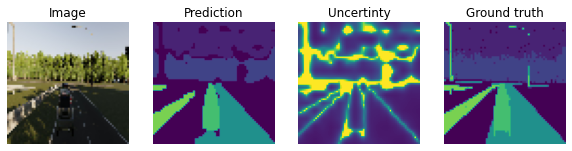

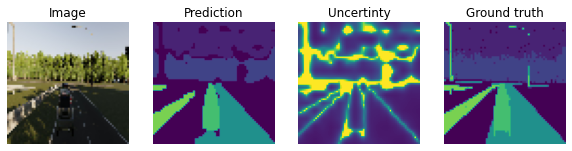

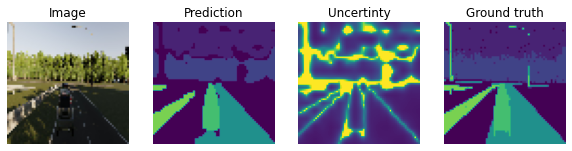

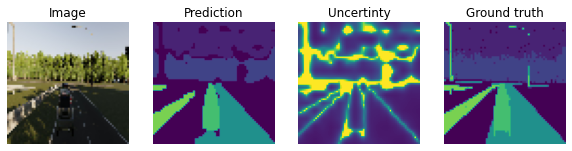

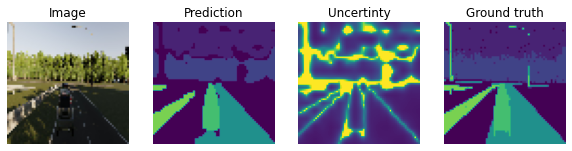

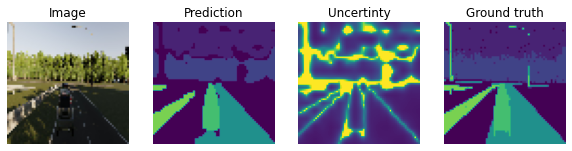

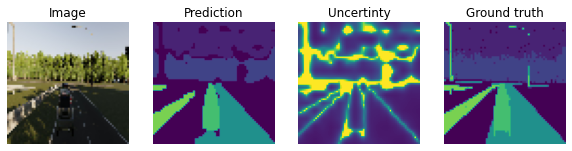

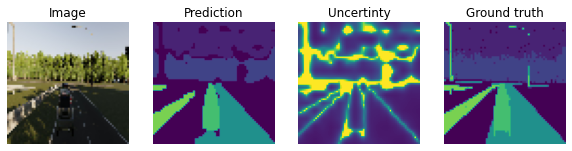

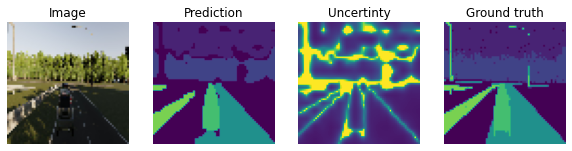

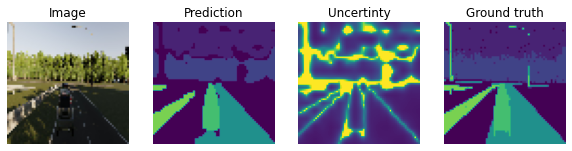

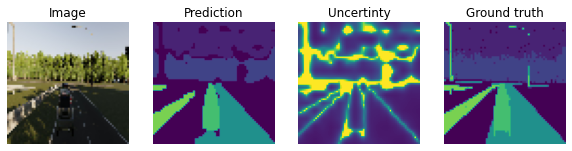

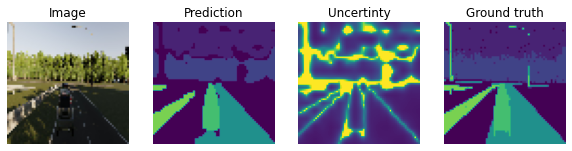

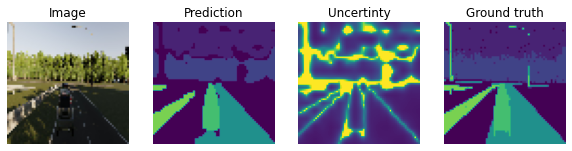

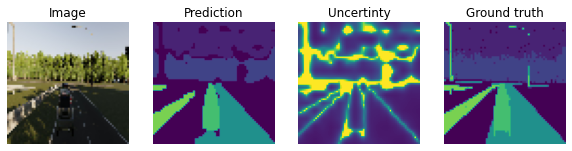

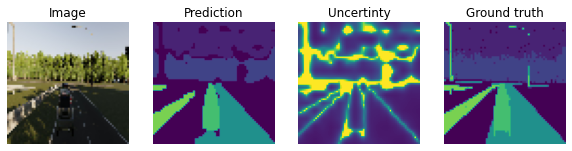

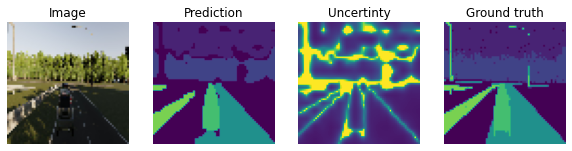

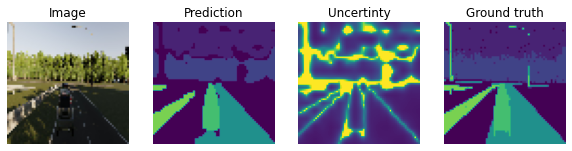

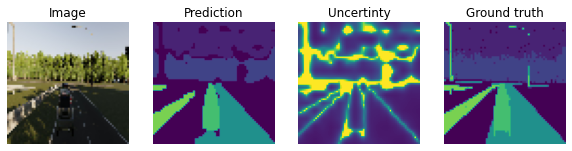

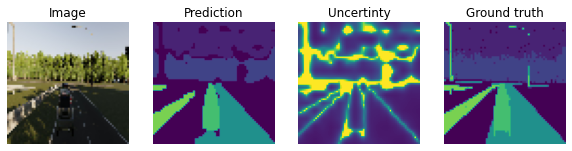

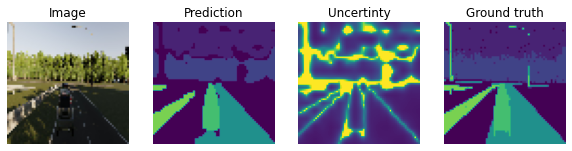

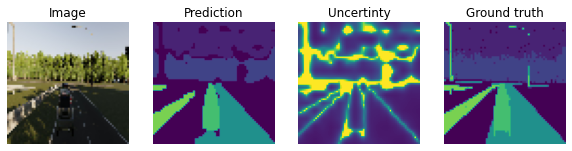

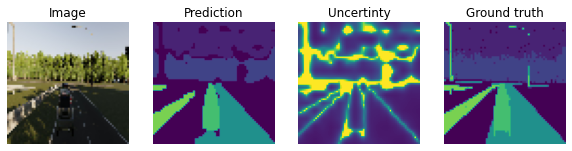

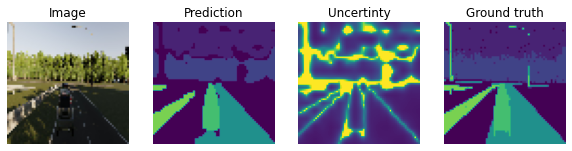

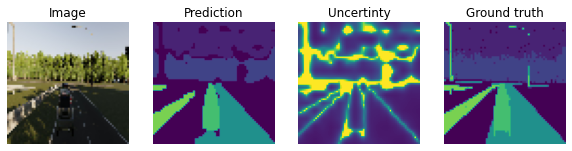

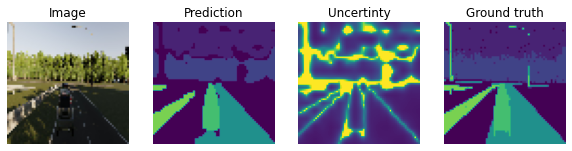

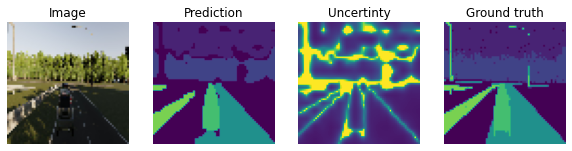

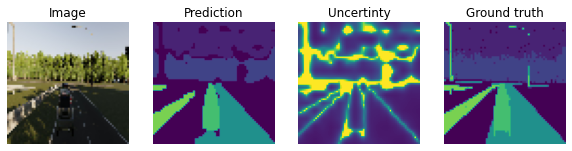

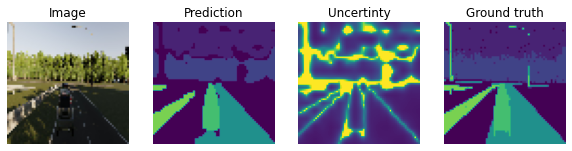

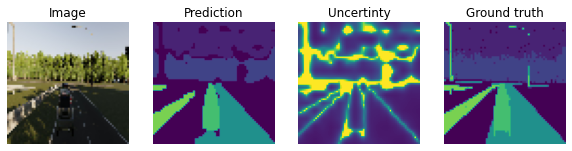

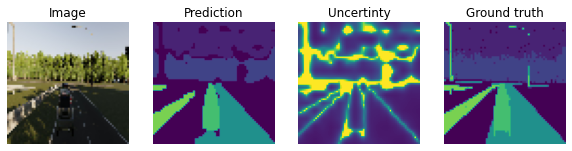

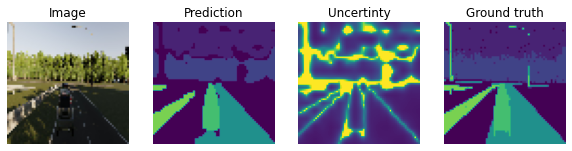

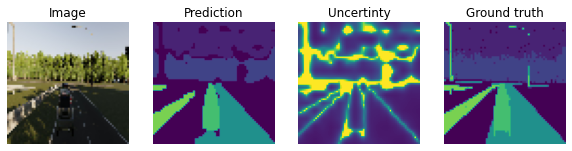

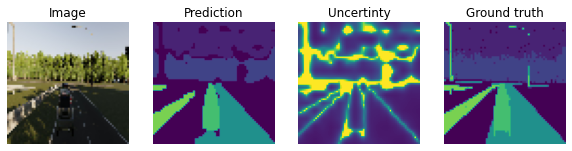

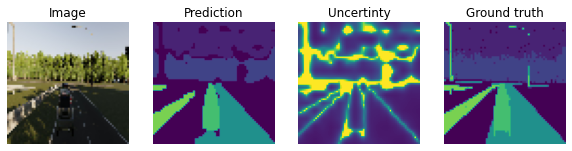

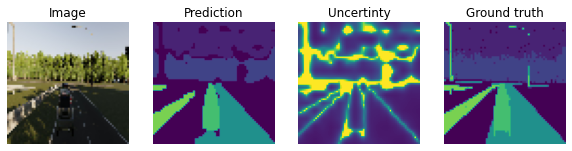

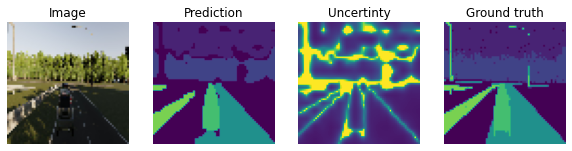

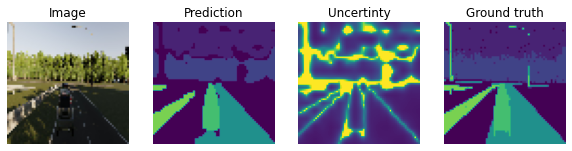

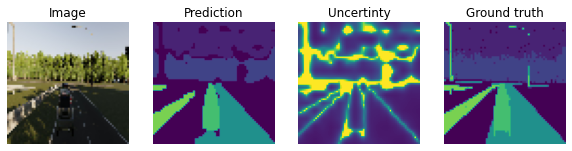

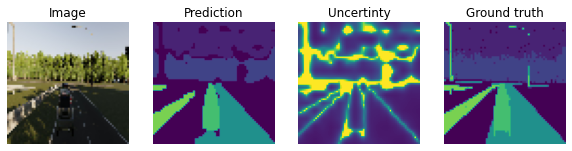

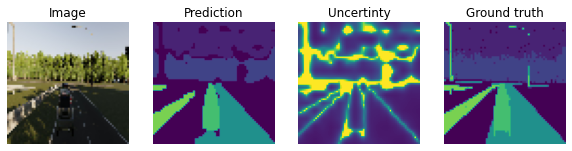

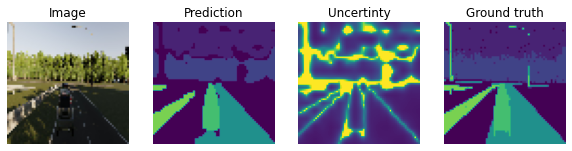

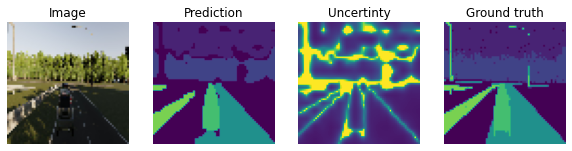

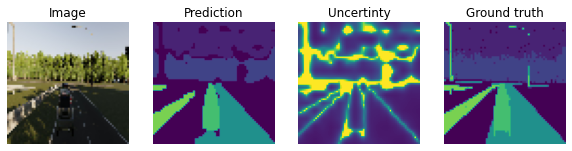

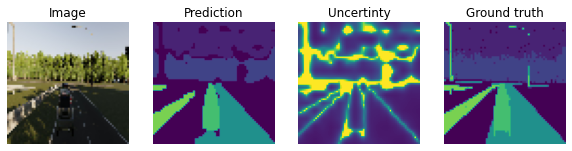

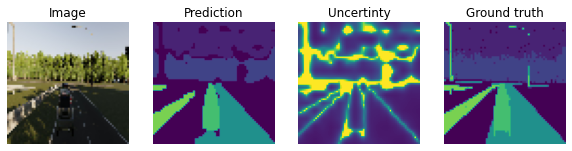

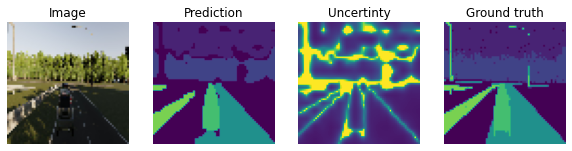

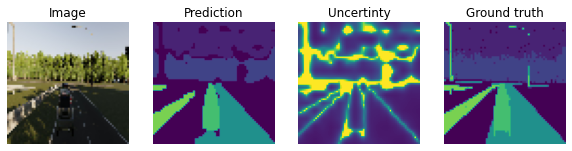

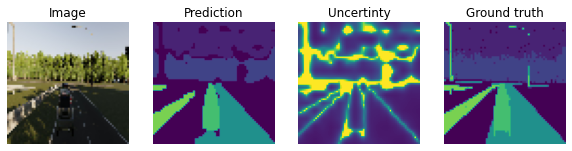

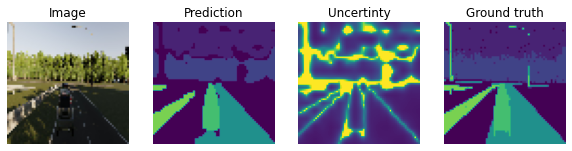

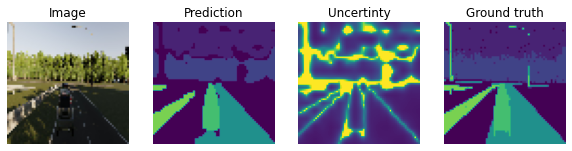

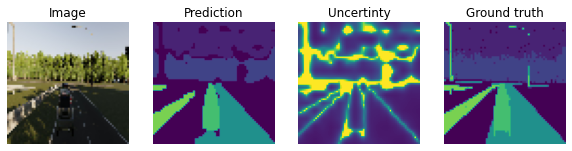

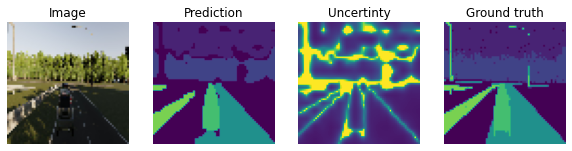

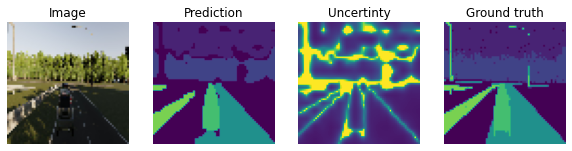

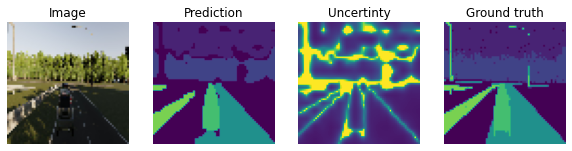

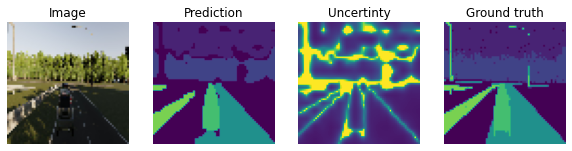

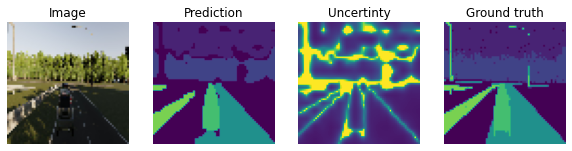

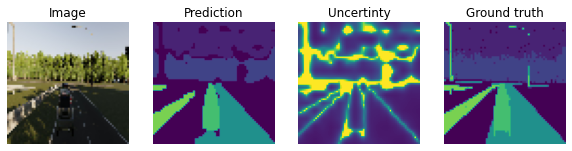

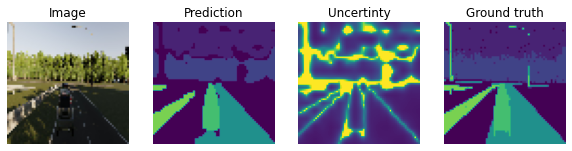

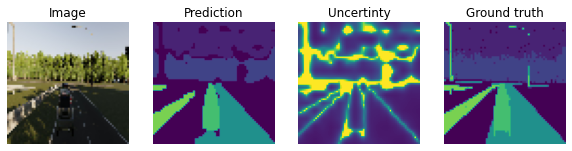

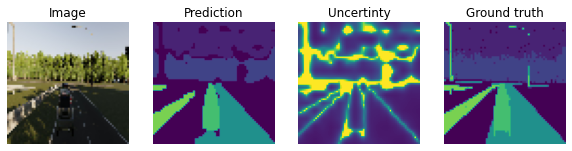

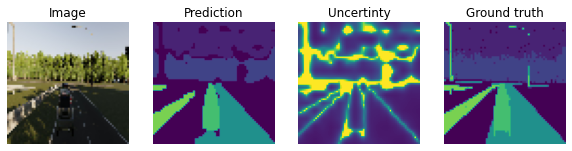

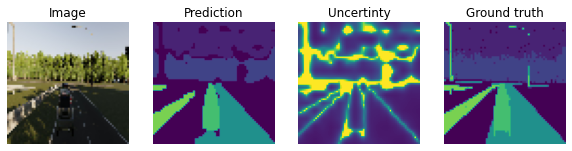

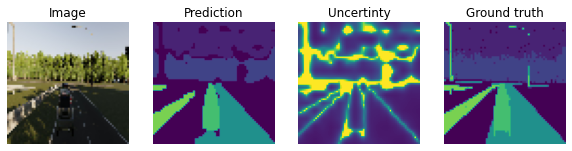

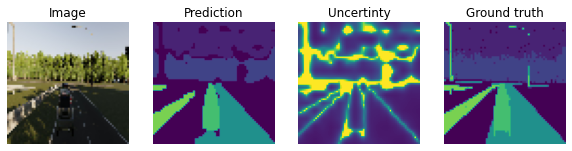

In [26]:
batch = next(iter(loaders['valid']))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
#pr_masks = logits.sigmoid()
#prob_mask = logits.log_softmax(dim=1).exp()
evidence  = torch.relu(logits)
alpha = evidence + 1
pred_mask = alpha.argmax(dim=1, keepdim=True)
sum_evidence = torch.sum(alpha, dim=1, keepdim=True)
uncertainty = 9 / sum_evidence
#print (sum_evidence.shape, uncertainty.shape)
for image, gt_mask, pr_mask, u in zip(batch["image"], batch["mask"], pred_mask, uncertainty):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(gt_mask.numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(pr_mask.numpy().squeeze(), vmin=0, vmax=10) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")
  
    plt.subplot(1, 4, 3)
    plt.imshow(u.numpy().squeeze(), vmin=0, vmax=1) # just squeeze classes dim, because we have only one class
    plt.title("Uncertinty")
    plt.axis("off")
    
    #plt.savefig('result.png')
    plt.show()
    

del batch, logits, evidence,alpha ,pred_mask,sum_evidence,uncertainty

In [28]:
torch.save(model.model, './vkitti_mobilenetv3_64s_10epoch_77a.pt')

In [21]:
transforms = torch.nn.Sequential(
            #RandomHorizontalFlip(p=0.50),
            Resize(size=(255,255)),
            RandomChannelShuffle(p=0.50),
            RandomThinPlateSpline(p=0.50),
            RandomEqualize(p=0.5),
            RandomGaussianBlur((3, 3), (0.1, 2.0), p=0.2),
            RandomGaussianNoise(mean=0., std=1., p=0.2),
            RandomSharpness(0.5, p=0.5)
        )
x= torch.rand(64, 3, 512, 1024, device='cuda')

In [22]:
%%timeit
transforms(x)

58 ms ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
x= torch.rand(64, 3, 64, 64, device='cuda')

In [20]:
%%timeit
transforms(x)

37.8 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
filenames = pd.read_csv(root+'/virtual_kiti_file_naming.csv')

In [12]:
filenames

Unnamed: 0    scene     scenario camera_number  frame_number  \
0               0  Scene01  15-deg-left      Camera_0             0   
1               1  Scene01  15-deg-left      Camera_0             1   
2               2  Scene01  15-deg-left      Camera_0             2   
3               3  Scene01  15-deg-left      Camera_0             3   
4               4  Scene01  15-deg-left      Camera_0             4   
...           ...      ...          ...           ...           ...   
42515       42515  Scene20       sunset      Camera_1           832   
42516       42516  Scene20       sunset      Camera_1           833   
42517       42517  Scene20       sunset      Camera_1           834   
42518       42518  Scene20       sunset      Camera_1           835   
42519       42519  Scene20       sunset      Camera_1           836   

                                               extrinsic  
0      [-0.008019686, 0.07217909, -0.9973595, 7.49445...  
1      [-0.007779241, 0.0730738, -0.9972962, 7.283874...  
2      [-0.008015394, 0.06971319, -0.9975349, 6.62668...  
3      [-0.008151174, 0.06922305, -0.997568, 6.289214...  
4      [-0.007937193, 0.06872611, -0.9976041, 5.91949...  
...                                                  ...  
42515  [-0.7014188, -0.01358945, -0.7126198, -111.951...  
42516  [-0.7014475, -0.01355444, -0.7125923, -111.909...  
42517  [-0.7014322, -0.01353448, -0.712608, -111.9159...  
42518  [-0.7014487, -0.01356346, -0.7125909, -111.904...  
42519  [-0.7014234, -0.01355547, -0.7126161, -111.921...  

[42520 rows x 6 columns]

In [13]:
filenames = filenames.values.tolist()

In [25]:
_, scene, scenario, camera, frame_number, x = filenames[0]
data_filename = scene+'_'+scenario+'_'+camera+'_'+str(frame_number).zfill(5)+'.h5'
data_filename = os.path.join(root, data_filename)
data_filename

'/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/Scene01_15-deg-left_Camera_0_00000.h5'

In [26]:
with h5py.File(data_filename, 'r') as data: 
    pass

In [24]:
!ls /home/deebuls/Documents/phd/dataset/virtual_kitti_h5/Scene01_15-deg-left_Camera_0_00000.h5

/home/deebuls/Documents/phd/dataset/virtual_kitti_h5/Scene01_15-deg-left_Camera_0_00000.h5
